In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import holidays
from sklearn.metrics import mean_squared_error

In [2]:
data = pd.read_excel(r"C:\Users\kriti\kriti python\Hourly Patient Data.xlsx")


In [3]:
data['Time'] = pd.to_datetime(data['Time'])

In [4]:
data.set_index('Time', inplace=True)

In [5]:
data.drop(columns=['ESI 1', 'ESI 2', 'ESI 4', 'ESI 5'], inplace=True)

In [6]:
esi1_daily = data['ESI 3'].resample('D').sum()

In [7]:
esi1_daily_df = esi1_daily.reset_index()

In [8]:
esi1_daily_df.columns = ['Date', 'ESI 3']

In [9]:
print(esi1_daily_df)

           Date  ESI 3
0    2017-01-01    116
1    2017-01-02    111
2    2017-01-03    138
3    2017-01-04    159
4    2017-01-05    133
...         ...    ...
1456 2020-12-27    107
1457 2020-12-28    124
1458 2020-12-29    125
1459 2020-12-30    121
1460 2020-12-31    115

[1461 rows x 2 columns]


In [10]:
train = esi1_daily_df.iloc[:int(len(esi1_daily_df)*0.9)]
test = esi1_daily_df.iloc[int(len(esi1_daily_df)*0.9):]

In [11]:
us_holidays = holidays.US(years=range(2017, 2021))

In [12]:
train['Date'] = pd.to_datetime(train['Date'])
train['Holiday'] = train['Date'].apply(lambda x: int(x in us_holidays))
train['Day_of_Week'] = train['Date'].dt.day_name()
train['Month'] = train['Date'].dt.month
train['Trend'] = range(1, len(train) + 1)

C:\Users\kriti\AppData\Local\Temp\ipykernel_24384\2476409844.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['Date'] = pd.to_datetime(train['Date'])
C:\Users\kriti\AppData\Local\Temp\ipykernel_24384\2476409844.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['Holiday'] = train['Date'].apply(lambda x: int(x in us_holidays))
C:\Users\kriti\AppData\Local\Temp\ipykernel_24384\2476409844.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using

In [13]:

train.rename(columns={'ESI 3': 'ESI_3'}, inplace=True)

res = smf.ols(formula='ESI_3 ~ C(Holiday) + C(Day_of_Week) + C(Month) + Trend + I(Trend**2) + I(Trend**3)', data=train).fit()


C:\Users\kriti\AppData\Local\Temp\ipykernel_24384\260121169.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train.rename(columns={'ESI 3': 'ESI_3'}, inplace=True)


In [14]:
test['Date'] = pd.to_datetime(test['Date'])
test['Holiday'] = test['Date'].apply(lambda x: int(x in us_holidays))
test['Day_of_Week'] = test['Date'].dt.day_name()
test['Month'] = test['Date'].dt.month
test['Trend'] = range(len(train) + 1, len(train) + len(test) + 1)

C:\Users\kriti\AppData\Local\Temp\ipykernel_24384\2015112868.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Date'] = pd.to_datetime(test['Date'])
C:\Users\kriti\AppData\Local\Temp\ipykernel_24384\2015112868.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Holiday'] = test['Date'].apply(lambda x: int(x in us_holidays))
C:\Users\kriti\AppData\Local\Temp\ipykernel_24384\2015112868.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

In [15]:
ypred = res.predict(test)

In [16]:
# Check the column names in train and test data
print(train.columns)



Index(['Date', 'ESI_3', 'Holiday', 'Day_of_Week', 'Month', 'Trend'], dtype='object')


In [17]:
# Check the column names in train and test data

print(test.columns)


Index(['Date', 'ESI 3', 'Holiday', 'Day_of_Week', 'Month', 'Trend'], dtype='object')


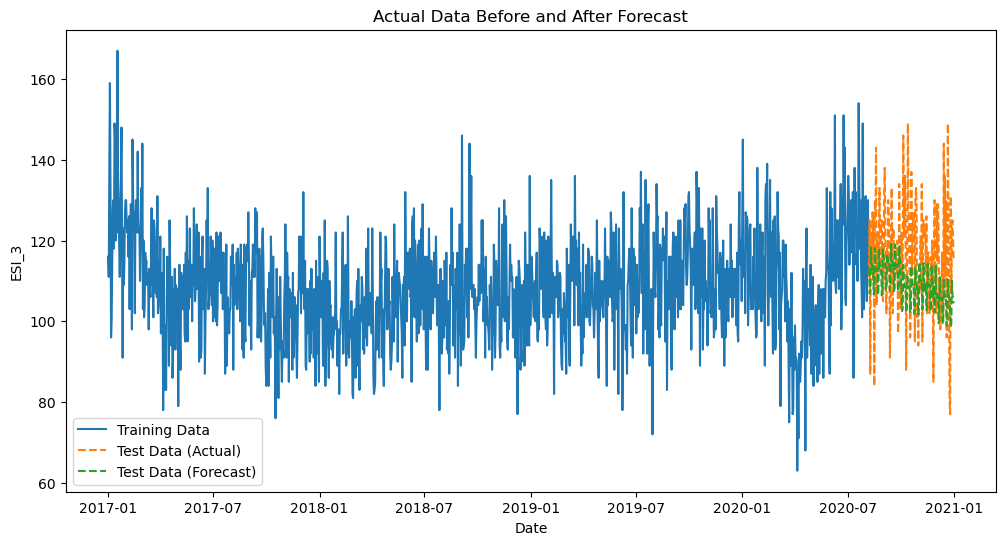

In [18]:
plt.figure(figsize=(12, 6))
plt.plot(train['Date'], train['ESI_3'], label='Training Data')
plt.plot(test['Date'], test['ESI 3'], label='Test Data (Actual)', linestyle='--')
plt.plot(test['Date'], ypred, label='Test Data (Forecast)', linestyle='--')
plt.xlabel('Date')
plt.ylabel('ESI_3')
plt.title('Actual Data Before and After Forecast')
plt.legend()
plt.show()


In [19]:
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [20]:
mape = mean_absolute_percentage_error(test['ESI 3'], ypred)
print("MAPE:", mape)

MAPE: 9.199725412227199


In [21]:
rmse = np.sqrt(mean_squared_error(test['ESI 3'], ypred))
print("RMSE:", rmse)

RMSE: 14.091776758943551


In [22]:
import numpy as np

def mean_absolute_error(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))



mae = mean_absolute_error(test['ESI 3'], ypred)
print("MAE:", mae)

MAE: 10.90742256890568
